In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import print_function
import numpy as np
from numpy import array
import optparse
import codecs
import sys
from subprocess import call


In [3]:
from sklearn.calibration import calibration_curve, _sigmoid_calibration
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import brier_score_loss
from sklearn.exceptions import NotFittedError

In [4]:
from g2p import readApply, loadG2PSample
from sequitur import Translator
from SequiturTool import procureModel

In [5]:
class fakeOptParser(object):
    def __init__(self):
        self.modelFile = '/home/thomas/cognitive-backend/ML/TranslationModel/Xval/model-6'
        self.encoding = 'ISO-8859-15'
        self.shouldRampUp = False
        self.newModelFile = None
        self.shouldTranspose = False
        self.shouldSelfTest = False
        self.resume_from_checkpoint = False
        self.trainSample = None

options = fakeOptParser()
encoder, decoder, streamReader, streamWriter = codecs.lookup(options.encoding)
stdout = streamWriter(sys.stdout)


In [6]:
def readSource(fname):
    res = []
    with open(fname) as fi:
        for line in fi:
            word = line.strip()
            left = tuple(word)
            res.append( (word, left))
    return res
def readDest(fname):
    res = []
    with open(fname) as fi:
        for line in fi:
            res.append( line.strip())
    return res
def readLex(fname):
    X = []
    y = []
    with open(fname) as fi:
        for line in fi:
            # TODO: write logic to ensure ocr and valid data are aligned correctly! 
            ocr = line.split()[0] 
            X.append(ocr)
            valid = ''.join(line.split('\t')[1].strip().split())
            y.append(valid)
    return X,y
def writeLex(ocr,valid,fname):
    with open(fname,'w') as fo:
        for o, v in zip(ocr,valid):
            fo.write("{}\t{}\n".format(o,' '.join(list(v))))
def yieldWordTuple(a_list):
    for word in a_list:
        yield word, tuple(word)

In [7]:
class JSM(object):
    """Joint-Sequence model"""
    
    def __init__(self,options,translator=None,source=None,dest=None):
        self.translator = translator
        self.options = options
    def yieldWordTuple(a_list):
        for word in a_list:
            yield word, tuple(word)
    def fit(self):
        pass
    def predict(self,source, dest=None,verbose=False, test=True):
        """Give best prediction(s) for a list of @param source strings
        If validated test strings are avaiable, set @param dest to list of validdated
        strings--the results will be printed
        posterior probabilities and predicted strings are stored in
        self.pred and self.prob respectivly
        """
        
        self.source = source
        self.dest = dest
        if self.translator is None:
            raise NotFittedError("This instance has no trained model")
        threshold = 1
        nVariantsLimit = 1
        words = yieldWordTuple(self.source)
        pred = []
        true = []
        prob = []
        i = 0
        if test:
            print  ('{}\t{}\t{:26}\t{:26}\t{}'.format( 't/f','posterior','ocr', 'predicted','validated'))
        if not test and verbose:
            print  ('{}\t{:26}\t{:26}'.format('posterior','ocr', 'predicted'))
        for word, left in words:
            true.append(word)
            try:
                totalPosterior = 0.0
                nVariants = 0 # this fn needs to be refactored before this can be changed
                nBest = self.translator.nBestInit(left)
                while totalPosterior < threshold and nVariants < nVariantsLimit:
                    
                    try:
                        logLik, result = self.translator.nBestNext(nBest)
                    except StopIteration:
                        break
                    posterior = np.exp(logLik - nBest.logLikTotal) # posterior = likelihood / obser
                    if test:
                        print  ('{}\t{:.3f}\t{:26}\t{:26}\t{}'.format(int(''.join(result)==self.dest[i]) ,posterior,word, ''.join(result),self.dest[i]))
                    if not test and verbose:
                        print  ('{:.3f}\t\t{:26}\t{:26}'.format(posterior,word, ''.join(result)))
                    pred.append(''.join(result))
                    prob.append(posterior)
                    totalPosterior += posterior
                    nVariants += 1
                    
            except self.translator.TranslationFailure, exc:
                pred.append('NULL')
                prob.append(0)
                if verbose:
                    print ('failed to convert "%s": %s' % (word, exc))    
            i += 1
        self.pred = pred
        self.prob = np.array(prob)
  
    def score(self):
        scr = []
        for pred,true in zip(self.pred,self.dest):
            if pred == true:
                scr.append(1)
            else:
                scr.append(0)
        self.support = np.array(scr)
        return self.support.mean()
        

In [8]:
ocr,valid = readLex('/home/thomas/cognitive-backend/ML/TranslationModel/Xval/all.lex')

In [9]:
print(len(ocr))

3742


In [10]:
def removeDups(test_ocr,test_valid):
    tmpocr = []
    tmpvalid = []
    for i in range(len(test_ocr)):
        if test_ocr[i] != test_valid[i]:
            tmpocr.append(test_ocr[i])
            tmpvalid.append(test_valid[i])
    return tmpocr,tmpvalid

In [11]:
def getScore(train_ocr,train_valid,test_ocr,test_valid):
    """Write the data to filesytem
    train on training set @param train_ocr and @param train_valid
    test on testing set @param test_oct and @param test_valid
    """
    writeLex(train_ocr,train_valid,'train.lex')
    writeLex(test_ocr,test_valid,'test.lex')
    call(['bash', 'startTrain.sh'])
    model = procureModel(options, loadG2PSample, log=stdout)
    translator = Translator(model)
    jsm = JSM(options,translator=translator)
    jsm.predict(test_ocr,test_valid)
    return jsm.score()
def xval(ocr,valid,train_size=.8,n_splits=10, data_lim=1):
    ss = ShuffleSplit(n_splits=n_splits,train_size=train_size,test_size=.2)
    scores = []
    for train_indicies, test_indicies in ss.split(ocr):
        train_ocr,test_ocr = [], []
        train_valid,test_valid = [],[]
        for i in train_indicies[:int(data_lim*len(train_indicies))]:
            train_ocr.append(ocr[i])
            train_valid.append(valid[i])
        for i in test_indicies[:int(data_lim*len(test_indicies))]:
            test_ocr.append(ocr[i])
            test_valid.append(valid[i])
        test_ocr,test_valid = removeDups(test_ocr,test_valid)
        print("Testing on",len(test_ocr))
        scores.append(getScore(train_ocr,train_valid,test_ocr,test_valid))
    return np.array(scores)

In [12]:
model = procureModel(options, loadG2PSample, log=stdout) #careful picking model-6 using unkown training data
translator = Translator(model)
jsm = JSM(options,translator=translator)
ocr_errors = [
    '$232.03',
    '9393-93`%932-0303',
    '233??',
    '35648-987'
] 
jsm.predict(ocr_errors,test=False)

In [13]:
def learning_curve(ocr,valid):
    X = []
    y = []
    for i in np.linspace(.05,.95,10):
        n_data = int(i*len(ocr))
        X.append(.8*n_data)
        y.append(xval(ocr,valid,train_size=.8,n_splits=5, data_lim=i,))
        print(X,y)
    return X,y
X,y = learning_curve(ocr,valid)

Testing on 3
t/f	posterior	ocr                       	predicted                 	validated
1	0.644	$43`50                    	43.50                     	43.50
0	0.705	12.70667                  	12.70667                  	12706.67
0	0.898	1.29500                   	1.29500                   	1295.00
Testing on 1
t/f	posterior	ocr                       	predicted                 	validated
0	0.593	172`.`M                   	172.M                     	172.84
Testing on 4
t/f	posterior	ocr                       	predicted                 	validated
0	0.948	35200                     	35200                     	352.00
0	0.520	888`48                    	88848                     	888.48
0	0.218	173017`RI                 	173017`RI                 	173017
0	0.262	L364`49                   	L364`49                   	1364.49
Testing on 4
t/f	posterior	ocr                       	predicted                 	validated
0	0.888	a                         	a                         	6
1	1.000	$1200.00 

In [17]:
# 5-fold xval on ~2000 data points 
#X= [223.20000000000002, 421.6, 620.0, 818.4000000000001, 1016.8000000000001, 1215.2, 1413.6000000000001, 1612.0, 1810.4, 2008.8000000000002] 
#y = [array([ 0.35714286,  0.41666667,  0.26666667,  0.33333333,  0.5       ]), array([ 0.42857143,  0.15      ,  0.53846154,  0.47058824,  0.33333333]), array([ 0.25      ,  0.41935484,  0.26923077,  0.5       ,  0.33333333]), array([ 0.47222222,  0.29787234,  0.25      ,  0.43181818,  0.48571429]), array([ 0.275     ,  0.41025641,  0.31914894,  0.45454545,  0.36206897]), array([ 0.46875   ,  0.32692308,  0.42857143,  0.34328358,  0.40322581]), array([ 0.375     ,  0.42622951,  0.27868852,  0.33766234,  0.625     ]), array([ 0.43421053,  0.42857143,  0.48611111,  0.47560976,  0.46987952]), array([ 0.5       ,  0.51685393,  0.37894737,  0.4       ,  0.43373494]), array([ 0.36893204,  0.45918367,  0.41052632,  0.41904762,  0.4953271 ])]

# 5-fold xval on ~5000 data points
X = [149.6, 448.8, 748.0, 1047.2, 1346.4, 1646.4, 1945.6000000000001, 2244.8, 2544.0, 2843.2000000000003] 
y = [array([ 0.33333333,  0.        ,  0.        ,  0.5       ,  0.2       ]), array([ 0.34782609,  0.29166667,  0.3125    ,  0.28571429,  0.05      ]), array([ 0.53125   ,  0.28571429,  0.46428571,  0.55      ,  0.41025641]), array([ 0.41860465,  0.46511628,  0.54285714,  0.5483871 ,  0.4047619 ]), array([ 0.328125  ,  0.45      ,  0.48979592,  0.48148148,  0.53448276]), array([ 0.46376812,  0.44117647,  0.49122807,  0.38961039,  0.43373494]), array([ 0.46067416,  0.53164557,  0.3902439 ,  0.42696629,  0.56      ]), array([ 0.52173913,  0.48780488,  0.48543689,  0.5212766 ,  0.46153846]), array([ 0.4952381 ,  0.45794393,  0.46153846,  0.41284404,  0.49514563]), array([ 0.46      ,  0.44915254,  0.50961538,  0.5       ,  0.44736842])]
stds = np.array([s.std() for s in y])
means = np.array([s.mean() for s in y])


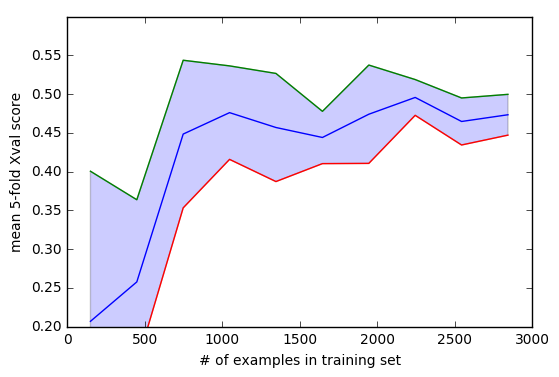

In [18]:
plt.plot(X,means)
plt.plot(X, stds+means)
plt.plot(X, means-stds)
plt.fill_between(X, means + stds, means - stds, alpha=0.2)

plt.xlabel('# of examples in training set')
plt.ylabel('mean 5-fold Xval score')
plt.ylim(.2,.6)
plt.show()

In [16]:
clf_score = brier_score_loss(jsm.support, jsm.prob, pos_label=1)
clf_score

AttributeError: 'JSM' object has no attribute 'support'

In [ ]:
m, b = _sigmoid_calibration(jsm.prob, jsm.support)
m,b

In [ ]:
1. / (1. + np.exp(m * .2 + b))